<font size="6"> **Modelling**

In this notebook, the train and test set exported from the previous notebook will be used to develop a better perfomring machine learning algorithm to predict clients with risk.\
First, an imbalanced calssification issue of the dataset was discussed, and it will be dealt in this notebook. Different types of resampling techinque will be combined with different machine learning algorithms to identify the best resampling technique for the project. After, the most suitable resmapling technique will be used on imbalanced dataset for further development.\
Also, few numbers of classifiers will be chosen for hyperparameter tuning with resampled dataset. 
Lastly, after the classifier is chosen, the feature importance will be analyzed to understand the impact of each features on predicting clients' risk.


# Table of contents
1. [Import packages and load data](#1.-Import-packages-and-load-data)
2. [Dealing with Imbalanced Data](#2.-Dealing-with-Imbalanced-Data)
3. [Hyperparameter Tuning](#3.-Hyperparameter-Tuning)
4. [Interpretability and Feature Importance](#4.-Interpretability-and-Feature-Importance)\
    4.1 [Logistic Regression Feature Importance](#4.1-Logistic-Regression-Feature-Importance)\
    4.2 [RandomForest Feature Importance](#4.2-RandomForest-Feature-Importance)\
    4.3 [SHAP Analysis with XGBoost](#4.3-SHAP-Analysis-with-XGBoost)
5. [Conclusion](#5.-Conclusion)

## 1. Import packages and load data 

In [4]:
import pickle

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, roc_curve, auc,ConfusionMatrixDisplay

In [7]:
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb

In [8]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
#from sklearn.pipeline import make_pipeline

In [9]:
from imblearn.pipeline import make_pipeline

In [10]:
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

In [11]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

In [12]:
from sklearn.base import TransformerMixin

In [13]:
from imblearn.over_sampling import SMOTE,RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import TomekLinks

In [14]:
from sklearn.model_selection import RandomizedSearchCV

In [15]:
from sklearn.model_selection import GridSearchCV

In [16]:
pkl_file = open('X_train.pkl', 'rb')
X_train = pickle.load(pkl_file)
pkl_file.close()

In [17]:
pkl_file = open('X_test.pkl', 'rb')
X_test = pickle.load(pkl_file)
pkl_file.close()

In [18]:
pkl_file = open('y_train.pkl', 'rb')
y_train = pickle.load(pkl_file)
pkl_file.close()

In [19]:
pkl_file = open('y_test.pkl', 'rb')
y_test = pickle.load(pkl_file)
pkl_file.close()

In [17]:
df=pd.read_csv('../Capstone-3-/data.csv')

In [18]:
df

Id   Income  Age  Experience Marital_Status House_Ownership  \
0            1  1303834   23           3         SINGLE          RENTED   
1            2  7574516   40          10         SINGLE          RENTED   
2            3  3991815   66           4        MARRIED          RENTED   
3            4  6256451   41           2         SINGLE          RENTED   
4            5  5768871   47          11         SINGLE          RENTED   
...        ...      ...  ...         ...            ...             ...   
251995  251996  8154883   43          13         SINGLE          RENTED   
251996  251997  2843572   26          10         SINGLE          RENTED   
251997  251998  4522448   46           7         SINGLE          RENTED   
251998  251999  6507128   45           0         SINGLE          RENTED   
251999  252000  9070230   70          17         SINGLE          RENTED   

       Car_Ownership           Profession  Job_Yrs  House_Yrs  Risk_Flag  
0                 NO  MECHANICAL_ENGINEER        3         13          0  
1                 NO   SOFTWARE_DEVELOPER        9         13          0  
2                 NO     TECHNICAL_WRITER        4         10          0  
3                YES   SOFTWARE_DEVELOPER        2         12          1  
4                 NO        CIVIL_SERVANT        3         14          1  
...              ...                  ...      ...        ...        ...  
251995            NO              SURGEON        6         11          0  
251996            NO         ARMY_OFFICER        6         11          0  
251997            NO      DESIGN_ENGINEER        7         12          0  
251998            NO     GRAPHIC_DESIGNER        0         10          0  
251999            NO         STATISTICIAN        7         11          0  

[252000 rows x 11 columns]

In [22]:
X_train.shape

(176400, 63)

In [23]:
y_train.shape 

(176400, 1)

## 2. Dealing with Imbalanced Data

Dictionary with different resampling techinques inclduing oversampling, and undersampling and another dictionary with different classifiers are created to find the best perfroming resampling techniques for the model.

In [50]:
resamplers={}
resamplers['SMOTE']=SMOTE()
resamplers['AD']=ADASYN()
resamplers['Random under Sampler']=RandomUnderSampler()
resamplers['Random over Sampler']=RandomOverSampler()
resamplers['TomekLinks']=TomekLinks()

In [51]:
classifiers = {}
classifiers['LR'] = LogisticRegression()
classifiers['DT'] = DecisionTreeClassifier()
classifiers['RF'] = RandomForestClassifier()
classifiers['KNN'] = KNeighborsClassifier()
classifiers['LGBM'] = LGBMClassifier()
classifiers['XGB'] = xgb.XGBClassifier(objective="binary:logistic", use_label_encoder=False, eval_metric='logloss')

Classification Report, Accuracy score and Area under the curve were calculated and stored for evaluation.

In [52]:
scores = {}
cls_report= {}
scores['Accuracy'] = pd.DataFrame(columns=classifiers.keys(), index=resamplers.keys())
scores['AUC'] = pd.DataFrame(columns=classifiers.keys(), index=resamplers.keys())

In [53]:
for model in classifiers.keys():
    for resampler in resamplers.keys():
        pipe = make_pipeline(resamplers[resampler], classifiers[model])
        pipe.fit(X_train, y_train)
        scores['Accuracy'].loc[resampler,model] = pipe.score(X_test, y_test)
        scores['AUC'].loc[resampler,model] = roc_auc_score(y_test, pipe.predict(X_test))
        cls_report[resampler,model]=classification_report(y_test, pipe.predict(X_test))

Classification Report of each classifer and resampling technique combinations are plotted.

In [56]:
for key, value in cls_report.items():
...     print(key,'\n', value)

('SMOTE', 'LR') 
               precision    recall  f1-score   support

           0       0.89      0.64      0.75     66301
           1       0.15      0.45      0.22      9299

    accuracy                           0.62     75600
   macro avg       0.52      0.55      0.49     75600
weighted avg       0.80      0.62      0.68     75600

('AD', 'LR') 
               precision    recall  f1-score   support

           0       0.88      0.81      0.84     66301
           1       0.15      0.24      0.18      9299

    accuracy                           0.74     75600
   macro avg       0.52      0.52      0.51     75600
weighted avg       0.79      0.74      0.76     75600

('Random under Sampler', 'LR') 
               precision    recall  f1-score   support

           0       0.89      0.52      0.66     66301
           1       0.14      0.56      0.23      9299

    accuracy                           0.52     75600
   macro avg       0.52      0.54      0.44     75600
weighted

In [280]:
scores['Accuracy']

LR        DT        RF       KNN      LGBM  \
SMOTE                 0.618995  0.871019  0.887646  0.851415  0.760767   
AD                    0.738532   0.87254  0.886799  0.847288  0.813638   
Random under Sampler   0.52336  0.848161  0.874339  0.829167  0.744841   
Random over Sampler   0.525013  0.877487  0.893889  0.862831  0.762487   
TomekLinks            0.876997  0.881905   0.89914  0.887804  0.878161   

                           XGB  
SMOTE                 0.839974  
AD                     0.85295  
Random under Sampler  0.799286  
Random over Sampler   0.821548  
TomekLinks            0.885397

In [55]:
scores['AUC']

LR        DT        RF       KNN      LGBM  \
SMOTE                 0.545722   0.85495  0.843395  0.860277   0.73967   
AD                    0.523868  0.852673  0.845409   0.85515  0.716512   
Random under Sampler  0.540754   0.85477  0.848105  0.828731  0.740021   
Random over Sampler   0.542205  0.848837   0.84261  0.855413  0.741852   
TomekLinks                 0.5  0.751781   0.74834  0.728194  0.506997   

                           XGB  
SMOTE                 0.799389  
AD                    0.776185  
Random under Sampler  0.807257  
Random over Sampler   0.806728  
TomekLinks            0.564608

As showm above, the SMOTE resampling technique from oversampler performed well throughout the whole classifiers therefore, SMOTE resampler will be used to deal with the imbalanced classification of the dataset.

SMTOE will be used to resample the training sets of our model.

In [20]:
sm=SMOTE()
X_train_sm,y_train_sm=sm.fit_resample(X_train,y_train)
#new train sets without imbalanced classification issue

New train and test sets are prepared with SMOTE resmapling technique for future use.

## 3. Hyperparameter Tuning

Next, list of classifiers chosen from scores above with different parameters for each classifiers are created and for loop that creates pipeline and preforms randomized search for each classifier is developed.

RandomziedsearchCV was used for the hyperparameter tuning to save time and also recall score was prioritized for our project to minimize the number of False Negatives. It is crucial for clients when they think they will be approved for loan application but getting rejected then it causes more time and money. Therefore it was important for our models to minimize the number of false negatives and maximize the True positives.

In [25]:
names = [
        "Logistic Regression",
         "RandomForestClassifier",
         "LGBMClassifier",
         "XGBClassifier"
        ]

classifiers = [
    LogisticRegression(),
    RandomForestClassifier(),
    LGBMClassifier(),
    xgb.XGBClassifier(objective="binary:logistic", use_label_encoder=False, eval_metric='logloss')
    
]

parameters = [
              {"clf__penalty": ['l2','l1'],
               "clf__C": np.logspace(0,1, 4, 10)}, #logistic regression
              {'clf__n_estimators':[100,1000],
               'clf__max_depth':[0,4,5,6,8],
               'clf__criterion':['gini','entropy'],
               'clf__max_features':['sqrt', 'log2', None],
               'clf__min_samples_split':[1,2,3]}, #Random Forest
              {'clf__learning_rate': [0.1,0.01,0.0001],
               'clf__num_leaves': [31,140,200],
               'clf__boosting_type' : ['gbdt'],
               'clf__objective' : [None,'binary'],
               'clf__max_depth' : [-1,5,7]},#LGBM
              {'clf__max_depth': [3, 6, 10],
               'clf__learning_rate': [0.1, 0.2, 0.3],
               'clf__subsample': np.arange(0.6, 0.8, 1.0),
              'clf__n_estimators': [100, 500, 1000],}#xgb
              ]

for name, classifier, params in zip(names, classifiers, parameters):
    clf_pipe = Pipeline([('clf', classifier)])
    gs_clf = RandomizedSearchCV(clf_pipe, param_distributions=params, n_jobs=None,scoring='recall')
    clf = gs_clf.fit(X_train_sm, y_train_sm)
    score = clf.score(X_test, y_test)
    best_param=clf.best_params_
    roc_score=roc_auc_score(y_test, gs_clf.predict(X_test))
    cls_report=classification_report(y_test, gs_clf.predict(X_test))
    print("{} accuracy score: {}".format(name, score))
    print("{} best parameters: {}".format(name,best_param))
    print("{} roc_auc: {}".format(name,roc_score))
    print("{} confusion matrix: {}".format(name,cls_report))

Logistic Regression accuracy score: 0.43821916335089794
Logistic Regression best parameters: {'clf__penalty': 'l2', 'clf__C': 1.0}
Logistic Regression roc_auc: 0.5429885578598201
Logistic Regression confusion matrix:               precision    recall  f1-score   support

           0       0.89      0.65      0.75     66301
           1       0.15      0.44      0.22      9299

    accuracy                           0.62     75600
   macro avg       0.52      0.54      0.49     75600
weighted avg       0.80      0.62      0.69     75600

RandomForestClassifier accuracy score: 0.596945908162168
RandomForestClassifier best parameters: {'clf__n_estimators': 1000, 'clf__min_samples_split': 2, 'clf__max_features': 'sqrt', 'clf__max_depth': 8, 'clf__criterion': 'entropy'}
RandomForestClassifier roc_auc: 0.6331737881559848
RandomForestClassifier confusion matrix:               precision    recall  f1-score   support

           0       0.92      0.67      0.78     66301
           1       0.2

Classification report of each classifiers with best parameters are plotted. As it was mentioned above, recall score was optimized with the hyperparameters. The classifiers with parameter tuned performed better in terms of obtaining recall score compare to the classifiers with default parameters.

In [20]:
lr_best=LogisticRegression(penalty='l2', C= 1.0)
lr_best.fit(X_train_sm,y_train_sm)
lrpred=lr_best.predict(X_test)

In [21]:
RF_tuned=RandomForestClassifier(n_estimators= 1000, min_samples_split= 2, max_features= 'sqrt',max_depth= 8, criterion= 'entropy')
RF_tuned.fit(X_train_sm,y_train_sm)
RFpred=RF_tuned.predict(X_test)

In [22]:
lgbm_best=LGBMClassifier(clf__objective= None, clf__num_leaves= 200, clf__max_depth= -1, clf__learning_rate= 0.1, clf__boosting_type= 'gbdt')
lgbm_best.fit(X_train_sm,y_train_sm)
lgbmpred=lgbm_best.predict(X_test)

[LightGBM] [Warning] Unknown parameter: clf__max_depth
[LightGBM] [Warning] Unknown parameter: clf__num_leaves
[LightGBM] [Warning] Unknown parameter: clf__learning_rate
[LightGBM] [Warning] Unknown parameter: clf__boosting_type


In [23]:
best_xgb=xgb.XGBClassifier(objective="binary:logistic", use_label_encoder=False, eval_metric='logloss',subsample=0.6, n_estimators= 1000, max_depth= 10, learning_rate = 0.2)

In [24]:
best_xgb.fit(X_train_sm,y_train_sm)
xgbpred=best_xgb.predict(X_test)

In [360]:
pipe_dict = {0: 'Logistic Regression', 1: 'RandomForest', 2: 'LGBM',3:'XGBoost'}
fit_best=[lr_best,RF_tuned,lgbm_best,best_xgb]
result_best=[lrpred,RFpred,lgbmpred,xgbpred]

Accuracy scores are calculated for each classifiers with best estimators. The numbers may be lower than classifiers with default parameters. However, hyperparameter tuning was conducted with recall score prioritized to minimize the false negatives.

Also, confusion matrix and roc-auc are plotted for further evaluation.

In [367]:
for i,result in enumerate(fit_best):
    print(pipe_dict[i],result.score(X_test, y_test))

Logistic Regression 0.621984126984127
RandomForest 0.6502777777777777
LGBM 0.7491931216931217
XGBoost 0.8913359788359788


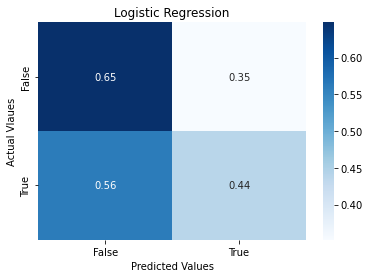

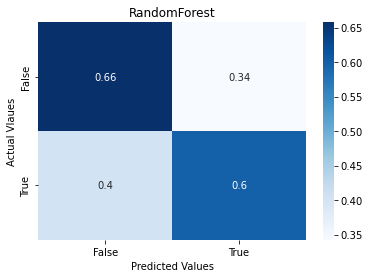

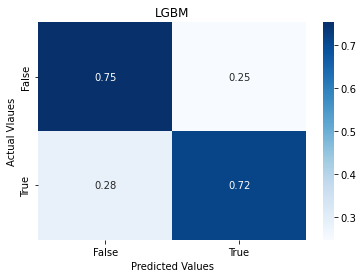

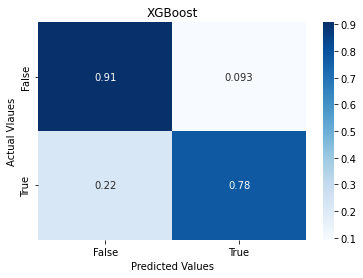

In [361]:
for i,result in enumerate(result_best):    
    cmn = confusion_matrix(y_test,result).astype('float') / confusion_matrix(y_test,result).sum(axis=1)[:, np.newaxis]
    _=sns.heatmap(cmn,annot=True,cmap='Blues')
    _.set_title(pipe_dict[i])
    _.set_xlabel('Predicted Values')
    _.set_ylabel('Actual Vlaues')
    _.xaxis.set_ticklabels(['False','True'])
    _.yaxis.set_ticklabels(['False','True'])
    plt.show()

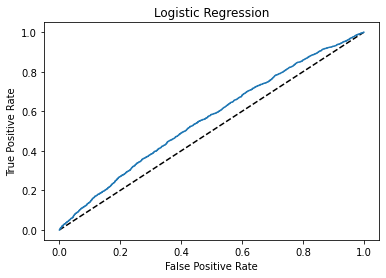

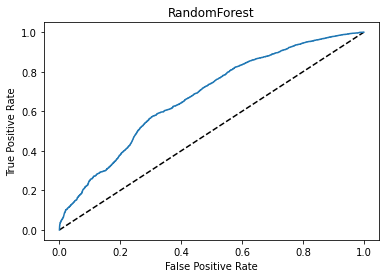

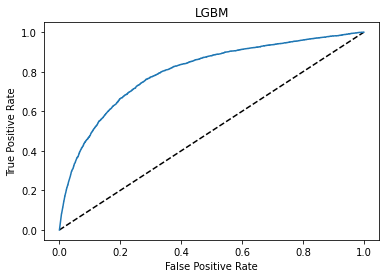

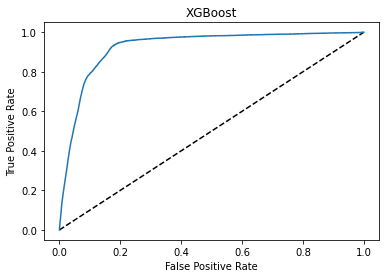

In [362]:
for i,result in enumerate(fit_best):
    y_scores=result.predict_proba(X_test)[:,1]
    f_lr,t_lr,_=roc_curve(y_test,y_scores)
    roc_auc=auc(f_lr,t_lr)
    round(roc_auc,2)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(f_lr, t_lr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(pipe_dict[i])
    plt.show()

As both the confusion matrix and ROC-AUC shows, XGBOOST performed the best compare to Logistic Regression, RandomForest and LGBM classifier with 89.13 percent accuracy score, 0.093 of flase positive and 84.23 percent of ROC-AUC.

### Table of Results

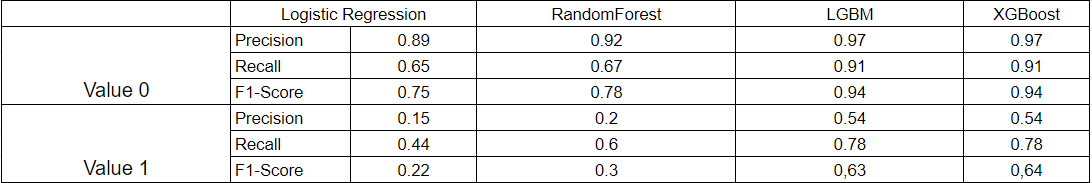

## 4. Interpretability and Feature Importance

 ### 4.1 Logistic Regression Feature Importance

Feature importance of the models are calculated for three different model algorithms inclduing Logistic Regression, RandomForest and XGBoost classifier.

First Logistic regression coefficient is used to calculate the feature importance. The coefficient of each columns are calculated.

In [109]:
lr_coef=lr_best.coef_

In [110]:
lr_coef=lr_coef[0]

In [111]:
feature_importance = abs(lr_coef)
feature_importance = 100.0 * (feature_importance / feature_importance.max())

In [112]:
lr_coef=pd.DataFrame([lr_coef],columns=X_train_sm.columns)
lr_coef

Income       Age  Experience   Job_Yrs  House_Yrs  \
0 -0.013573 -0.076551   -0.156368  0.051665  -0.014647   

   Marital_Status_MARRIED  Marital_Status_SINGLE  \
0               -3.944148              -3.551105   

   House_Ownership_NORENT_NOOWN  House_Ownership_OWNED  \
0                     -2.764088              -2.839913   

   House_Ownership_RENTED  ...  Profession_SCIENTIST  Profession_SECRETARY  \
0               -2.257058  ...             -4.378639             -4.617424   

   Profession_SOFTWARE_DEVELOPER  Profession_STATISTICIAN  Profession_SURGEON  \
0                      -4.405965                -4.678163           -4.773796   

   Profession_SURVEYOR  Profession_TECHNICAL_WRITER  Profession_TECHNICIAN  \
0            -4.383173                    -4.523484              -4.545067   

   Profession_TECHNOLOGY_SPECIALIST  Profession_WEB_DESIGNER  
0                         -5.203294                -4.751412  

[1 rows x 63 columns]

Logistic Regression coefficents are calculated and plotted in a dataframe, after three different categories are created, 1)negative coefficient values, 2)positive coefficent values and 3)coefficient in absolute values. 

In [113]:
lr_coef_pos=lr_coef.loc[:, lr_coef.ge(0).all()]

In [114]:
lr_coef_neg=lr_coef.loc[:, lr_coef.le(0).all()]

In [115]:
lr_coef_abs=pd.DataFrame([feature_importance],columns=X_train_sm.columns)

In [116]:
lr_coef_abs

Income       Age  Experience   Job_Yrs  House_Yrs  \
0  0.259614  1.464177    2.990814  0.988174   0.280144   

   Marital_Status_MARRIED  Marital_Status_SINGLE  \
0               75.438731              67.921088   

   House_Ownership_NORENT_NOOWN  House_Ownership_OWNED  \
0                     52.868023              54.318311   

   House_Ownership_RENTED  ...  Profession_SCIENTIST  Profession_SECRETARY  \
0               43.170179  ...             83.749129             88.316311   

   Profession_SOFTWARE_DEVELOPER  Profession_STATISTICIAN  Profession_SURGEON  \
0                       84.27178                89.478038           91.307195   

   Profession_SURVEYOR  Profession_TECHNICAL_WRITER  Profession_TECHNICIAN  \
0            83.835847                    86.519537              86.932355   

   Profession_TECHNOLOGY_SPECIALIST  Profession_WEB_DESIGNER  
0                           99.5221                90.879057  

[1 rows x 63 columns]

In [121]:
lr_coef_abs_top=lr_coef_abs.T.sort_values(by=0,ascending=False).head(10)
lr_coef_abs_top.rename(columns = {0:'Feature importance'}, inplace = True)

In [122]:
lr_coef_abs_bot=lr_coef_abs.T.sort_values(by=0).head(10)
lr_coef_abs_bot.rename(columns = {0:'Feature importance'}, inplace = True)

Top and bottom 10 important features with absolute values are plotted using bar plot.

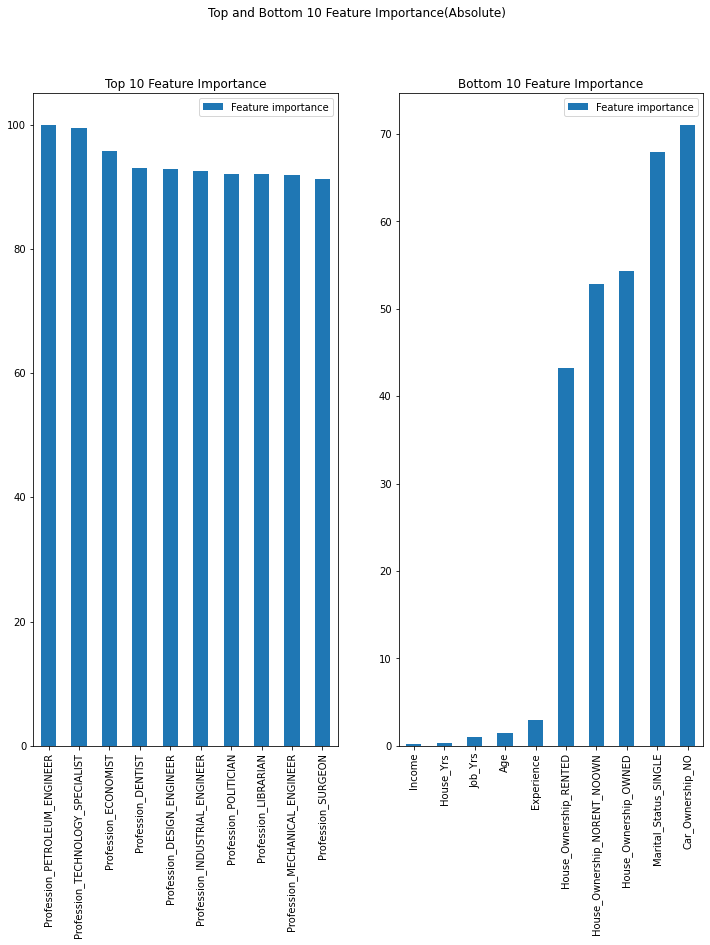

In [212]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(12,12))
fig.suptitle('Top and Bottom 10 Feature Importance(Absolute)')
ax1=lr_coef_abs_top.plot(ax=axes[0],kind='bar')
ax2=lr_coef_abs_bot.plot(ax=axes[1],kind='bar')
ax1.title.set_text('Top 10 Feature Importance')
ax2.title.set_text('Bottom 10 Feature Importance')

As the bar plots show, professions including engineer, tech specialist, economist, dentist, and industrital engineer are ranked at top 5. The features listed are the most important factors on predicting the clients' risk. Also Income, house years, job years, age and experience had the least effect on predicting the risk values.

After, the coefficients values are divided into positive and negative values. Both groups are plotted for evaluation.

In [145]:
lr_coef_pos=lr_coef_pos.T
lr_coef_pos.rename(columns = {0:'Feature importance'}, inplace = True)

In [142]:
lr_coef_neg=lr_coef_neg.T.sort_values(by=0).head(10)
lr_coef_neg.rename(columns = {0:'Feature importance'}, inplace = True)

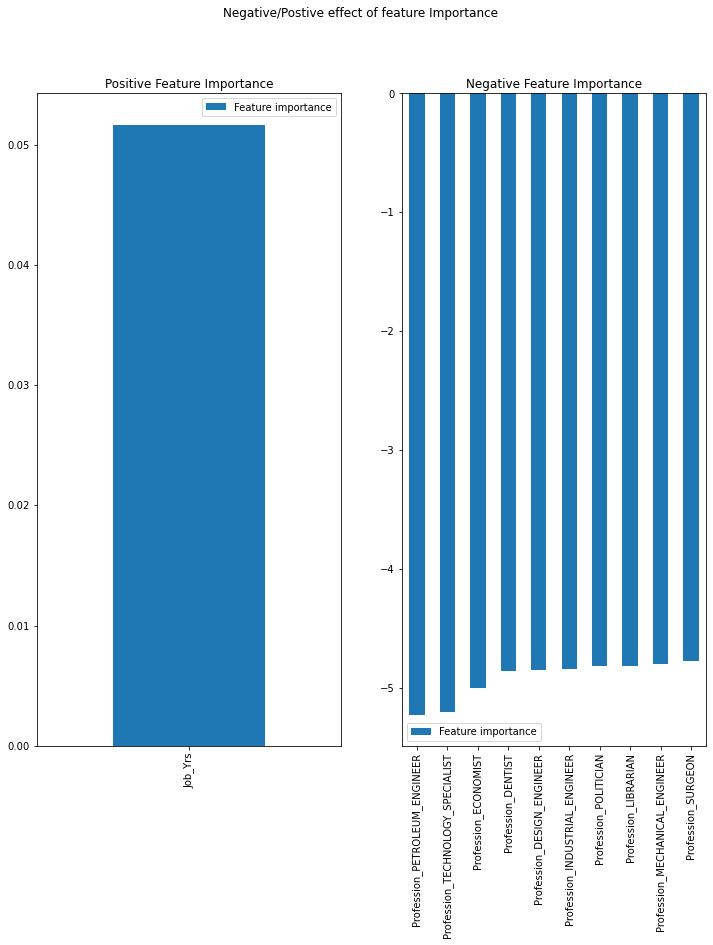

In [211]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(12,12))
fig.suptitle('Negative/Postive effect of feature Importance')
ax1=lr_coef_pos.plot(ax=axes[0],kind='bar')
ax1.title.set_text('Positive Feature Importance')
ax2=lr_coef_neg.plot(ax=axes[1],kind='bar')
ax2.title.set_text('Negative Feature Importance')

As the plot shows above, only job years had positive coefficient value and in our case postivie coefficient value represents positive affect to our target value which is 'no risk' for clients. Also, 10 features with the smallest coefficient values are plotted as well. Professions includes petroleum engineer, tech specialist, economist, design engineer and industrial engineer had negative impacts. It means the profession listed above had negative affect to our target value. 

Lastly, logistic regression coefficient values are grouped by categorical columns inclduing, marital status, house ownership, car ownership and profession.

In [39]:
martial_coef=df_coef[df_coef.columns[df_coef.columns.str.startswith('Marital_Status')]]

house_coef=df_coef[df_coef.columns[df_coef.columns.str.startswith('House_Ownership')]]

car_coef=df_coef[df_coef.columns[df_coef.columns.str.startswith('Car_Ownership')]]

prof_coef=df_coef[df_coef.columns[df_coef.columns.str.startswith('Profession')]]

In [149]:
martial_coef=martial_coef.T
martial_coef.rename(columns = {0:'Feature importance'}, inplace = True)
house_coef=house_coef.T
house_coef.rename(columns = {0:'Feature importance'}, inplace = True)
car_coef=car_coef.T
car_coef.rename(columns = {0:'Feature importance'}, inplace = True)

In [148]:
prof_coef=prof_coef.T.sort_values(by=0).head(10)
prof_coef.rename(columns = {0:'Feature importance'}, inplace = True)

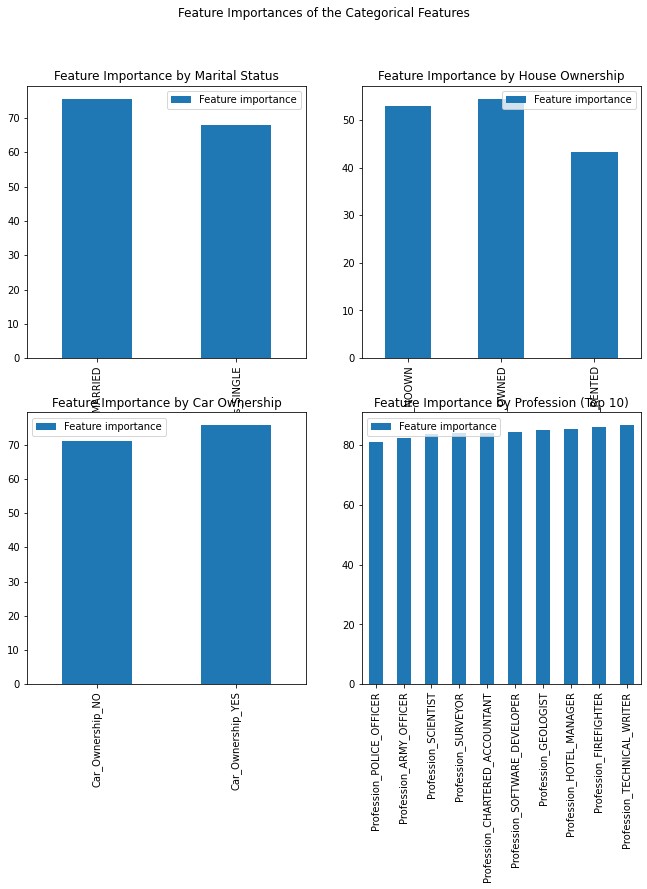

In [216]:
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(11,11))
fig.suptitle('Feature Importances of the Categorical Features')
ax1=martial_coef.plot(ax=axes[0,0],kind='bar')
ax2=house_coef.plot(ax=axes[0,1],kind='bar')
ax3=car_coef.plot(ax=axes[1,0],kind='bar')
ax4=prof_coef.plot(ax=axes[1,1],kind='bar')
ax1.title.set_text('Feature Importance by Marital Status')
ax2.title.set_text('Feature Importance by House Ownership')
ax3.title.set_text('Feature Importance by Car Ownership')
ax4.title.set_text('Feature Importance by Profession (Top 10)')

The bar plots above show feature importance by categorical columns. The plots say that married couple had higher coefficient value compare to single, 'house owned' group had strongest impact compare to 'Not Owned-Not rented' and 'Rented' group, and clients with car had higher coefficient value compare to withot car. Laslty, top 10 professions with highest impact to risk prediction is plotted as well.

### 4.2 RandomForest Feature Importance

The next classifier used was RandomForest Classifier. Feature importances function from the RandomForest classifier was used to obtain an array of values for all the columns. 

The feature_importances_ function was used to find the feature importance value with Random Fores Classifier. Also standard deviation was calculated and stored in dataframe for further analysis.

In [158]:
importances=RF_tuned.feature_importances_
importances

array([0.12241982, 0.13861687, 0.15658836, 0.1431207 , 0.0589512 ,
       0.02246245, 0.01615769, 0.01576144, 0.02493892, 0.02237246,
       0.02101947, 0.02513125, 0.002872  , 0.00292317, 0.00513338,
       0.00288039, 0.00204414, 0.00256694, 0.00190217, 0.00448882,
       0.00211458, 0.00639803, 0.00218606, 0.00235912, 0.0070691 ,
       0.00294537, 0.00485825, 0.00267184, 0.01139499, 0.00214484,
       0.00368524, 0.00804056, 0.01338469, 0.00262718, 0.00345842,
       0.0041566 , 0.00136113, 0.00374049, 0.00190724, 0.00475721,
       0.00194802, 0.00451735, 0.00204686, 0.00442829, 0.00132495,
       0.00471031, 0.00322268, 0.00072806, 0.02150965, 0.00647172,
       0.00519417, 0.0069263 , 0.00383744, 0.00274582, 0.00132623,
       0.00263361, 0.00407788, 0.004191  , 0.00295853, 0.00576245,
       0.00333595, 0.01624903, 0.00624114])

In [160]:
std = np.std([tree.feature_importances_ for tree in RF_tuned.estimators_], axis=0)

In [161]:
std1=pd.Series(std,index=X_train_sm.columns)

In [163]:
std1

Income       Age  Experience   Job_Yrs  House_Yrs  \
0  0.045434  0.051158    0.072063  0.067334   0.038839   

   Marital_Status_MARRIED  Marital_Status_SINGLE  \
0                0.016037               0.013807   

   House_Ownership_NORENT_NOOWN  House_Ownership_OWNED  \
0                      0.016823                0.02033   

   House_Ownership_RENTED  ...  Profession_SCIENTIST  Profession_SECRETARY  \
0                0.019225  ...              0.005023              0.003737   

   Profession_SOFTWARE_DEVELOPER  Profession_STATISTICIAN  Profession_SURGEON  \
0                       0.005111                 0.007247            0.007266   

   Profession_SURVEYOR  Profession_TECHNICAL_WRITER  Profession_TECHNICIAN  \
0             0.005763                     0.010528               0.005708   

   Profession_TECHNOLOGY_SPECIALIST  Profession_WEB_DESIGNER  
0                          0.015452                 0.010292  

[1 rows x 63 columns]

In [164]:
std1=pd.DataFrame(std1).T

In [166]:
series_std = std1.squeeze()

In [170]:
series_std.sort_values(ascending=False)

Experience                        0.072063
Job_Yrs                           0.067334
Age                               0.051158
Income                            0.045434
House_Yrs                         0.038839
                                    ...   
Profession_BIOMEDICAL_ENGINEER    0.003970
Profession_FIREFIGHTER            0.003821
Profession_SECRETARY              0.003737
Profession_MAGISTRATE             0.003464
Profession_OFFICIAL               0.002436
Name: 0, Length: 63, dtype: float64

In [175]:
series_std_top=forest_importances.sort_values(ascending=False).head(9)
series_std_bot=forest_importances.sort_values(ascending=True).head(9)

In [168]:
forest_importances = pd.Series(importances, index=X_train_sm.columns)

In [174]:
forest_importances_top=forest_importances.sort_values(ascending=False).head(9)
forest_importances_bot=forest_importances.sort_values(ascending=True).head(9)

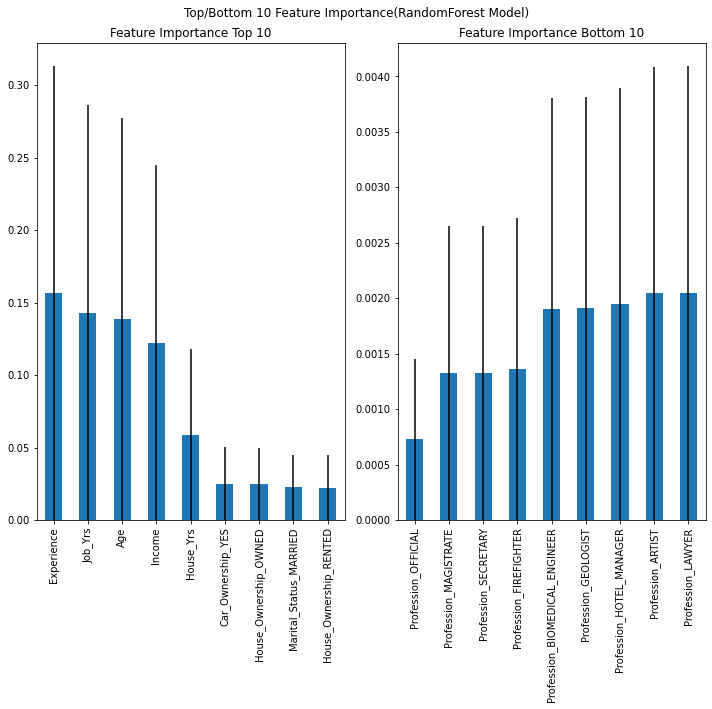

In [217]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10,10))
fig.suptitle('Top/Bottom 10 Feature Importance(RandomForest Model)')
ax1=forest_importances_top.plot.bar(yerr=series_std_top, ax=axes[0])
ax2=forest_importances_bot.plot.bar(yerr=series_std_bot, ax=axes[1])
ax1.title.set_text('Feature Importance Top 10')
ax2.title.set_text('Feature Importance Bottom 10')
fig.tight_layout()

Top and bottom 10 important features are plotted. Interestingly, 'profession' was not considered an important feature in Random Forest Classifier. Experience, job years, age, income and house years are the features with high importance value. Also professions inclduing Official, Magistrate, Secretary, Firefighter and Biomedical Engineer were considered the least important features on predicting our targe value.

For feature importances in Random Forest Classifiers, the categorical columns are seperated again for further analysis within the categorical groups.

In [221]:
std1=std1.T

In [222]:
martial_std=std1[std1.columns[std1.columns.str.startswith('Marital_Status')]]

house_std=std1[std1.columns[std1.columns.str.startswith('House_Ownership')]]

car_std=std1[std1.columns[std1.columns.str.startswith('Car_Ownership')]]

prof_std=std1[std1.columns[std1.columns.str.startswith('Profession')]]

In [249]:
prof_std=prof_std.T.sort_values(by=0,ascending=False).head(10)

In [236]:
fi=fi.T

In [235]:
fi

0
Income                            0.122420
Age                               0.138617
Experience                        0.156588
Job_Yrs                           0.143121
House_Yrs                         0.058951
...                                    ...
Profession_SURVEYOR               0.002959
Profession_TECHNICAL_WRITER       0.005762
Profession_TECHNICIAN             0.003336
Profession_TECHNOLOGY_SPECIALIST  0.016249
Profession_WEB_DESIGNER           0.006241

[63 rows x 1 columns]

In [234]:
fi=pd.DataFrame(forest_importances)

In [237]:
martial_fi=fi[fi.columns[fi.columns.str.startswith('Marital_Status')]]

house_fi=fi[fi.columns[fi.columns.str.startswith('House_Ownership')]]

car_fi=fi[fi.columns[fi.columns.str.startswith('Car_Ownership')]]

prof_fi=fi[fi.columns[fi.columns.str.startswith('Profession')]]

In [245]:
prof_fi=prof_fi.head(10)

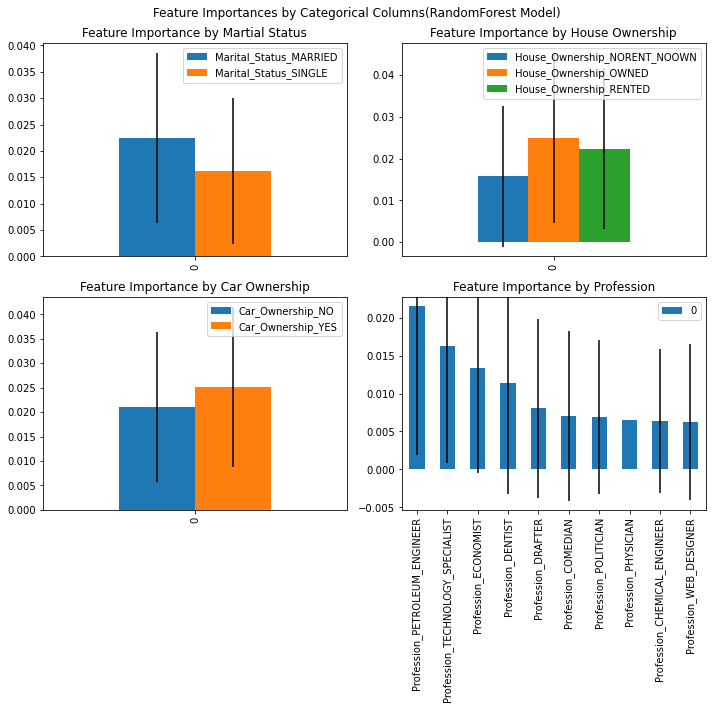

In [250]:
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(10,10))
fig.suptitle('Feature Importances by Categorical Columns(RandomForest Model)')
ax1=martial_fi.plot.bar(yerr=martial_std, ax=axes[0,0])
ax2=house_fi.plot.bar(yerr=house_std, ax=axes[0,1])
ax3=car_fi.plot.bar(yerr=car_std, ax=axes[1,0])
ax4=prof_fi.plot.bar(yerr=prof_std, ax=axes[1,1])
ax1.title.set_text('Feature Importance by Martial Status')
ax2.title.set_text('Feature Importance by House Ownership')
ax3.title.set_text('Feature Importance by Car Ownership')
ax4.title.set_text('Feature Importance by Profession')
fig.tight_layout()

In Random Forest Classifier, as same as logistic regression, clietns in, 'Married','House Owned', and 'Car Owned' group had stronger importance value compare to other groups. Also in terms of profession, Petroleum Engineer, tech specialist, economist, dentist and drafter are considered the most important groups in predicting targe value.

 ### 4.3 SHAP Analysis with XGBoost

In [180]:
import shap

Lastly, the best performing model out of the three XGBoost Classifier was used to analyze the feature importancewith SHAP summary plots. 

SHAP values are calculated using tree explainer of XGBoost and the arrays of values are transformed into a dataframe with column names. After, the values are combined by categories to see the general importance of each feature by categories.

In [181]:
explainer = shap.TreeExplainer(best_xgb)

In [182]:
shap_values = explainer.shap_values(X_test)

In [183]:
shap_values

array([[-0.6379498 , -1.2161257 , -0.9822967 , ...,  0.07216865,
         0.04137829,  0.05423995],
       [-1.597585  , -1.036486  , -0.6227056 , ...,  0.02631806,
         0.02176438,  0.06002833],
       [-1.4928107 , -0.8515423 , -0.56237674, ...,  0.02905995,
         0.02691112, -2.903351  ],
       ...,
       [ 0.75828475, -0.02592045, -0.01385665, ...,  0.05884057,
         0.02925782,  0.04792549],
       [-0.5363535 , -0.47370997, -0.90058917, ...,  0.01425538,
         0.02029093,  0.00937574],
       [-2.044733  , -0.64791536, -0.17381917, ...,  0.04493363,
         0.03676518,  0.03690753]], dtype=float32)

A funtion was defined to add the values in the same categories.

In [185]:
from __future__ import print_function

import pandas as pd

categories = set(df.columns)

def correct_categories(cols):
    return [cat for col in cols for cat in categories if col.startswith(cat)]    

In [186]:
shap_values_=pd.DataFrame(shap_values,columns=X_train_sm.columns)

In [189]:
shap_values_=shap_values_.groupby(correct_categories(shap_values_.columns),axis=1).sum()

In [191]:
shap_values_=pd.DataFrame.to_numpy(shap_values_)

A summary plot of feature importance of each columns are plotted below.

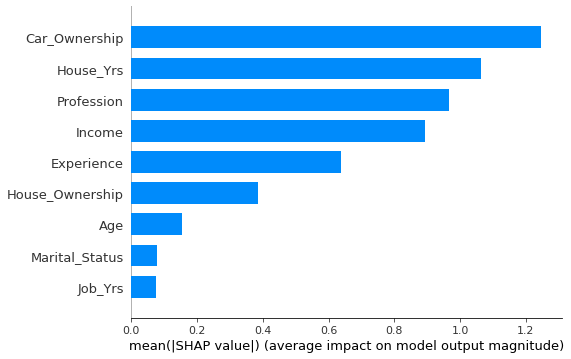

In [207]:
shap.summary_plot(shap_values_, X_test_, plot_type="bar", feature_names = X_test_.columns)

As the summary plot above shows, car ownership, house years and professions are the three most important features in predicting the target value in XGBoost classifier model. Also Age, marital status and job years are the three least important features in predicting the risk of clients.\
This is interesting, because car ownership and house years were not considered so important in other models but in XGBoost, which performed the best, the three features are considered the two most important features. Also, marital status of clients were one of the most important feature in both logistic regression and RandomForest classifer models, however it was considered one of the least important feature in XGBoost classifier model.

Lastly, another SHAP summary was plotted below.

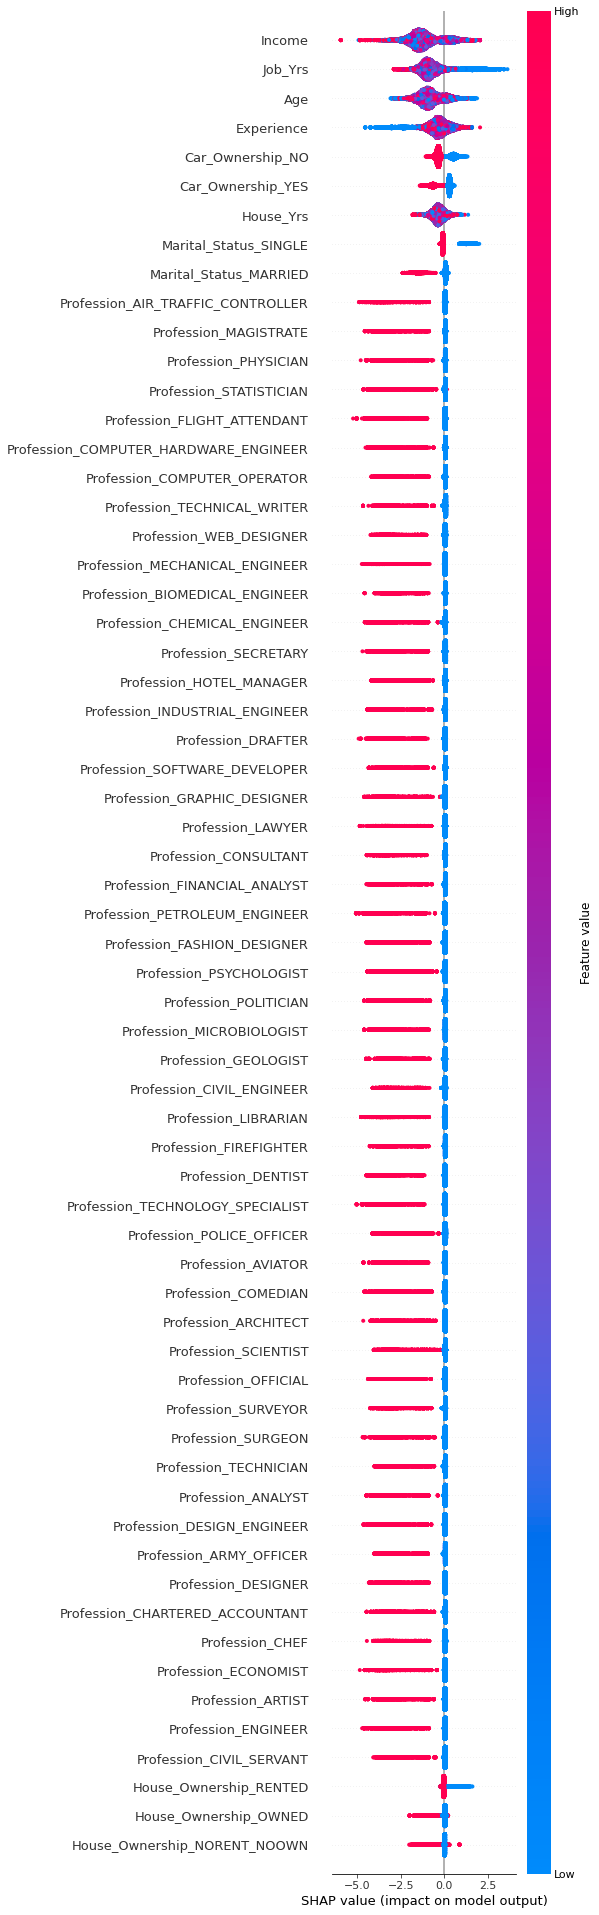

In [210]:
shap.summary_plot(shap_values,X_test,max_display=X_test.shape[1])

The summary plot above showed very interesting trend. Ther were clear features of clients that significantly affect the status of clients' risk and the top 5 features are analyzed.\
In terms of income, there are mixed of high and low income group for clients with high risk of loan status however, for clients with free of risk are all in high income group.\
In comparison, 'Job years' acted opposite as income. For clients who are free of risk contained both high and low job years, however, clients with risk only contained low job years group.\
In terms of age, young people had higher risk compare to older people but surprisingly, less experienced people had less risk compare to highly experienced clients.\
For car ownership and marital status, people with car had lower risk compare to people without vehichle and married clients clearly had lower risk compare to single clients. 

## 5. Conclusion

Thorugh this notebook, five different resampling techniques ADASYN, SMOTE, Random OverSampler, Random UnderSampler and Tomeklinks are applied on six different machine learning algorithms including Logistic Regression, RandomForest Classifier, DecisionTree Classifier, LGBM Classifier, KNN classifier and XGBoost Classifier to identify the best resampling technique and classifiers. According to the result, SMOTE resampling technique was chosen to deal with imbalanced classification from the previous notebook.

With a new train and test dataset resampled with SMOTE, hyperparameter tuning was conducted using four classifiers inclduing Logistic Regression, RandomForest, LGBM and XGBoost Classifiers. The hyperparameter tuning was conducted with optimizing recall score to minimize the False Negative.

Finally, classifiers are tuned with best parameters, XGBoost algorithm was selected for the model development. XGBoost performed well in terms of accuracy score, least number of false negatives, and Highest ROC-AUC score.

Lastly, feature importance of the models are calculated and visualized. Three modesl, Logistic Regression, RandomForest and XGBoost Classfiers' feature importances are calculated. For both the LogisticRegression and RandomForest classifier models identified 'Profession' as the most important feature. However, XGBoost classifier model identified 'Car Ownership' as the most important feature and 'Profession' was ranked third in terms of feature importance. 

In conclusion, selecting XGBoost Classifier model gave us 89.13 percent of accuracy score on predicting client's risk on loan approval.